In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
def setLogLevel(self, logLevel):
        """
        Control our logLevel. This overrides any user-defined log settings.
        Valid log levels include: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN
        """
        self._jsc.setLogLevel(logLevel)

In [16]:
from pyspark.sql import SparkSession

appName = "Spark - Setting Log Level"
master = "local"

# Create Spark session
spark = SparkSession.builder \
    .appName(appName) \
    .master(master) \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

23/03/30 16:11:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [17]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, BooleanType, FloatType

spark = SparkSession.builder.appName("crime_investigators").getOrCreate()


23/03/30 16:11:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [19]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

schema_dict = {
    "ID": IntegerType(),
    "Case Number": StringType(),
    "Date": StringType(),
    "Block": StringType(),
    "IUCR": StringType(),
    "Primary Type": StringType(),
    "Description": StringType(),
    "Location Description": StringType(),
    "Arrest": StringType(),
    "Domestic": StringType(),
    "Beat": IntegerType(),
    "District": IntegerType(),
    "Ward": IntegerType(),
    "Community Area": IntegerType(),
    "FBI Code": StringType(),
    "X Coordinate": DoubleType(),
    "Y Coordinate": DoubleType(),
    "Year": IntegerType(),
    "Updated On": StringType(),
    "Latitude": DoubleType(),
    "Longitude": DoubleType(),
    "Location": StringType(),
}

schema = StructType([StructField(k, v, True) for k, v in schema_dict.items()])


In [20]:
# Load Chicago crime data
chicago_crime_data = spark.read.csv("Crimes_-_2001_to_Present.csv", header=True, schema=schema)


In [21]:
# Remove all null values
chicago_crime_data = chicago_crime_data.na.drop()

In [22]:
from pyspark.sql.functions import to_timestamp
# Change 'Date' column data type
chicago_crime_data = chicago_crime_data.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))


In [23]:
from pyspark.sql.functions import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
# Filter data for last ten years

chicago_crime_data = chicago_crime_data.filter(col("Year") >= 2012) 

# Remove records with specific crime types
crime_types_to_remove = ['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']
chicago_crime_data = chicago_crime_data.filter(~chicago_crime_data["Primary Type"].isin(crime_types_to_remove)) 

# Merge similar crime types
chicago_crime_data = chicago_crime_data.withColumn("Primary Type", when(col("Primary Type").isin(["SEX OFFENSE", "PROSTITUTION"]), "SEX CRIME").otherwise(col("Primary Type"))) 


In [24]:
# Analyze the data
year_wise_crime = chicago_crime_data.groupBy("Year").count().orderBy("Year")
# Show year-wise trend of the crime for last ten years
year_wise_crime.show()



+----+------+
|Year| count|
+----+------+
|2012|   164|
|2013|   296|
|2014|   786|
|2015|155397|
|2016|242602|
|2017|240710|
|2018|239810|
|2019|113215|
|2020| 16179|
|2021|  2387|
|2022|    28|
+----+------+



In [25]:
hour_wise_crime = chicago_crime_data.groupBy(hour("Date")).count().orderBy("hour(Date)")
hour_wise_crime = hour_wise_crime.orderBy('count', ascending=False)
# Find out at which hour of the day crime is highest
hour_wise_crime.show(24)

+----------+-----+
|hour(Date)|count|
+----------+-----+
|        12|59452|
|        18|58908|
|        19|57821|
|        15|55634|
|        17|55455|
|        20|54602|
|        16|54474|
|        14|51503|
|        21|50787|
|        22|50017|
|        13|49082|
|         0|47411|
|        11|45698|
|         9|44699|
|        10|44001|
|        23|41802|
|         8|34917|
|         1|30873|
|         2|26658|
|         7|24605|
|         3|22195|
|         6|17949|
|         4|17583|
|         5|15448|
+----------+-----+



<function matplotlib.pyplot.show(close=None, block=None)>

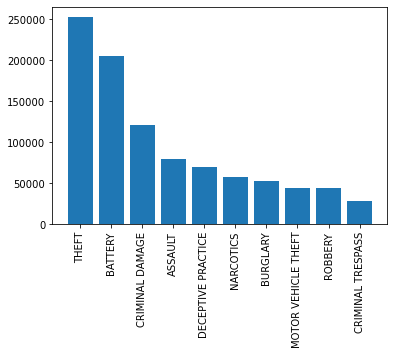

In [26]:

top_ten_crimes = chicago_crime_data.groupBy("Primary Type").agg(F.count("*").alias("Count")).orderBy(col("Count").desc()).limit(10)

# Plot top ten crimes as a bar chart
import matplotlib.pyplot as plt
import pandas as pd

df = top_ten_crimes.toPandas()
plt.bar(df['Primary Type'], df['Count'])
plt.xticks(rotation=90)
plt.show
